# Lab Assignment Seven: Recurrent Network Architectures

In this lab, we will select a prediction task to perform on our dataset, evaluate a recurrent architecture and tune hyper-parameters.

## Team Members:
1) Mohammed Ahmed Abdelrazek Aboelela

2) Naim Barnett

3) Katie Rink

## Dataset Selection

Data Set : Twitter Sentimental analysis Dataset - https://www.kaggle.com/datasets/cosmos98/twitter-and-reddit-sentimental-analysis-dataset?select=Twitter_Data.csv

## Overview and Business Understanding

From the public domain of Kaggle, we import this dataset that we think is most convinient for this lab pruproses. This was a dataaset created as a part of a university Project On Sentimental Analysis On Multi-Source Social Media Platform. These tweets were made on Narendra Modi and other Leaders as well as People's opinion towards the next Prime Minister of The Nation (In Context with General Elections Held In India - 2019). This dataset consists of around 163K tweets from the social media platform Twitter, it has two cloumns, the first column has the cleaned tweets and Comments and the Second one indicates its Sentimental Label. with Sentimental Label in the form:

{
0: Indicating it is a Neutral Tweet

1: Indicating a Postive Sentiment

-1: Indicating a Negative Tweet
}

We can create a business goal for this dataset in the following way: say we are hired by Twitter to speed up their detection for tweets that violate policies and rules. We expect tweets that have a positive sentiment and neutral tweets in general to not be violating the policies, however, negative tweets are more likely to contain words that are inappropriate and violate the codes of the platform. Thus, this classification will help in detecting the tweets that are more likely to be violating the codes of the platform (the negative tweets), and we end up with a binary classification problem more or less.

It is worth noting that we relied heavily on the professor's notebook, so everything I took from there will be cited with "(Inspired by the professor's notebook)" beforehand.

## Preparation

### Defining and preparing our class variables. Describing the final dataset that is used for classification. Discussing methods of tokenization in our dataset as well as any decisions to force a specific length of sequence.

In [90]:
"""Importing all the needed packages"""
import numpy as np
import pandas as pd
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'
import warnings
warnings.simplefilter('ignore', DeprecationWarning)
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing import sequence
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn import metrics as mt
from sklearn.model_selection import StratifiedKFold

In [91]:
"""Loading the Dataset"""
data = pd.read_csv('../../Data/Lab_7_Dataset/Twitter_Data.csv', low_memory=False)

# quick cleaning
data.dropna(inplace=True);
data = data.drop_duplicates()

# Specifying which datatypes you expect for each column
data['clean_text'] = data['clean_text'].astype(str)
data['category'] = data['category'].astype(int)

#Showing data
data.info()
data

<class 'pandas.core.frame.DataFrame'>
Int64Index: 162969 entries, 0 to 162979
Data columns (total 2 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   clean_text  162969 non-null  object
 1   category    162969 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 3.7+ MB


,clean_text,category
0,when modi promised “minimum government maximum...,-1
1,talk all the nonsense and continue all the dra...,0
2,what did just say vote for modi welcome bjp t...,1
3,asking his supporters prefix chowkidar their n...,1
4,answer who among these the most powerful world...,1
...,...,...
162975,why these 456 crores paid neerav modi not reco...,-1
162976,dear rss terrorist payal gawar what about modi...,-1
162977,did you cover her interaction forum where she ...,0
162978,there big project came into india modi dream p...,0


In [92]:
# Turning our problem to a binary classification one to be consistent with our business case
print("Before replacing:")
print(data["category"].value_counts())
print('================================')
data['category'].replace([-1,0],[0,1], inplace=True)
print("After replacing:")
print(data["category"].value_counts())

Before replacing:
 1    72249
 0    55211
-1    35509
Name: category, dtype: int64
After replacing:
1    127460
0     35509
Name: category, dtype: int64


In [93]:
"""Displaying a random tweet and its label"""
idx = round(np.random.rand()*data.shape[0])
print('--------Random Tweet---------')
print(data['clean_text'][idx])
print('================================')
print('Tweet Label: ',data['category'][idx])

--------Random Tweet---------
respected modi our bastar 300kms from raipur please provide exam centres jagdalpur for the exams 1ugc net 2csir ugc net 3ctet sirji govt efforts take the girls education positively but putting fee for them nios class 1012 not right
Tweet Label:  1


In [94]:
# making lists of the instances and targets ready to be tokenized
instances = data["clean_text"].to_list() 
target = data["category"].to_numpy()

In [95]:
"""(Inspired by the professor's notebook)"""

NUM_TOP_WORDS = None # use entire vocabulary!

# tokenize the text
tokenizer = Tokenizer(num_words=NUM_TOP_WORDS)
tokenizer.fit_on_texts(instances)
# save as sequences with integers replacing words
sequences = tokenizer.texts_to_sequences(instances)

word_index = tokenizer.word_index
NUM_TOP_WORDS = len(word_index) if NUM_TOP_WORDS==None else NUM_TOP_WORDS
top_words = min((len(word_index),NUM_TOP_WORDS))
print('Found %s unique tokens. Distilled to %d top words.' % (len(word_index),top_words))

X = pad_sequences(sequences)

y_ohe = keras.utils.to_categorical(target)
print('Shape of data tensor:', X.shape)
print('Shape of label tensor:', y_ohe.shape)
print(np.max(X))

Found 113678 unique tokens. Distilled to 113678 top words.
Shape of data tensor: (162969, 52)
Shape of label tensor: (162969, 2)
113678


Now, we have our final dataset that is ready for the sentiment classification task. We have our "X" tensor containing all the 162969 tweets, vectorized into a sequence of integers using the Keras text Tokenizer. We leave the default options of the tokenizer and the pad_sequences as we do not have massively big texts that we need to suppress or control (thanks to the limit on the character content of the tweets already imposed by Twitter :D). We also have our labels tensor as "y_ohe" in a one-hot encoded form.

X_train Shape: (130375, 52) Label Shape: (130375, 2)


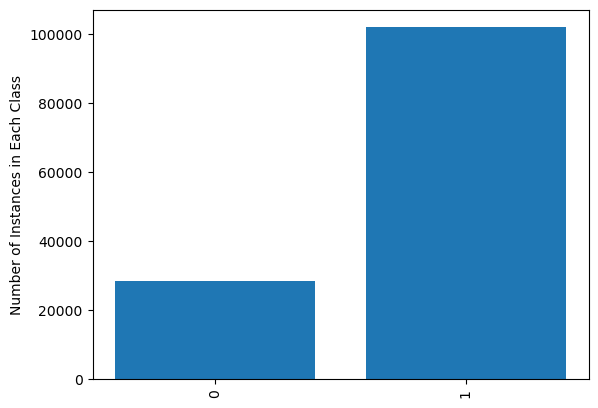

In [96]:
# Split it into train / test subsets
X_train, X_test, y_train_ohe, y_test_ohe = train_test_split(X, y_ohe, test_size=0.2,
                                                            stratify=target, 
                                                            random_state=42)
NUM_CLASSES = 2

# print some stats of the data
print("X_train Shape:",X_train.shape, "Label Shape:", y_train_ohe.shape)
uniq_classes = np.sum(y_train_ohe,axis=0)
plt.bar(list(range(2)),uniq_classes)
plt.xticks(list(range(2)), rotation='vertical')
plt.ylabel("Number of Instances in Each Class")
plt.show()

### Choosing and explaining what metric we will use to evaluate your algorithm’s performance.

For our business case that was already explained in the beginning of this notebook, it's more important for us to detect the negative tweets than detect the negative ones. In other words, having a false positive classification will be worse and less desirable than a false negative. Thus, we are looking to maximize the true positive out of the total predicted positives and consequently, the appropriate metric we decide to use is the "Precision" metric. 

### Choosing the method we will use for dividing our data for cross-validation

Since we have a kind of unbalanced data where one of the labels is significantly abundant than the other, we might be compelled to use Stratified 10-fold cross validation, to ensure that we have a good mirror of the original set and to also avoid having a significantly higher imbalance in during one set of cross-validation trainings. That's why we avoid using ShuffleSplits as we might end up having a severe imbalance during the training of one of the splits.

In [98]:
skf = StratifiedKFold(n_splits=10)
skf.get_n_splits(X_train, y_train_ohe)
print(skf)

StratifiedKFold(n_splits=10, random_state=None, shuffle=False)


## Modeling (6 points total)

### [3 points] Investigate at least two different recurrent network architectures (perhaps LSTM and GRU). Be sure to use an embedding layer (pre-trained, from scratch, OR both). Adjust hyper-parameters of the networks as needed to improve generalization performance (train a total of at least four models). Discuss the performance of each network and compare them.

### [1 points] Using the best RNN parameters and architecture, add a second recurrent chain to your RNN. The input to the second chain should be the output sequence of the first chain. Visualize the performance of training and validation sets versus the training iterations. 

### [2 points] Use the method of train/test splitting and evaluation criteria that you argued for at the beginning of the lab. Visualize the results of all the RNNs you trained.  Use proper statistical comparison techniques to determine which method(s) is (are) superior.  

## Exceptional Work (1 points total)

### One idea (required for 7000 level students to do one of these options):                                                                         Option 1: Use dimensionality reduction (choose an appropriate method from this list: t-SNE, SVD, PCA, or UMAP) to visualize the word embeddings of a subset of words in your vocabulary that you expect to have an analogy that can be captured by the embedding. Try to interpret if an analogy exists, show the vectors that support/refute the analogy, and interpret your findings.                                                                                                                                         Options 2: Use the ConceptNet Numberbatch embedding and compare to GloVe. Which method is better for your specific application? 

### One Idea (NOT required): Try to create a RNN for generating novel text. 

### You have free rein to provide additional analyses.